# Day 20

For each game, get the touchdowns (pass, rush, rec, special teams) and then see if any of those are significant different than the mean


I've heard analysts talk about the 2022 NFL Season being boring and/or low scoring. One metric we can look at is win margin, which is calculated as winning team's points - losing team's points. I want to see how the average win margin of games through Week 9 stacks up against previous seasons. If there is a significant difference in close games, maybe that can help to build a case that this NFL season isn't the most entertaining from an offensive standpoint.

## Set Up

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pingouin

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Get the data

In [3]:
query = """
WITH home_games AS (
    SELECT
        game_id,
        season,
        week,
        home_team AS team,
        home_score AS score
    FROM schedules
    WHERE week <= 9
        AND game_type = 'REG'
), away_games AS (
    SELECT
        game_id,
        season,
        week,
        away_team AS team,
        away_score AS score
    FROM schedules
    WHERE week <= 9
        AND game_type = 'REG'
), stacked AS (
    SELECT *
    FROM home_games
    UNION ALL
    SELECT *
    FROM away_games
), data AS (
    SELECT
        s.game_id,
        s.season,
        s.week,
        s.team,
        s.score,
        weekly_totals.tot_pass_tds,
        weekly_totals.tot_rush_tds,
        weekly_totals.tot_rec_tds, -- Will be equal to pass tds but keeping in just in case
        weekly_totals.tot_st_tds
        --(s.score / weekly_totals.tot_pass_tds + weekly_totals.tot_rush_tds) AS score_off_td_pct
    FROM stacked s
    LEFT JOIN (
        SELECT
            season,
            week,
            recent_team,
            SUM(passing_tds) AS tot_pass_tds,
            SUM(rushing_tds) AS tot_rush_tds,
            SUM(receiving_tds) AS tot_rec_tds,
            SUM(special_teams_tds) AS tot_st_tds
        FROM weekly
        GROUP BY season, week, recent_team
    ) AS weekly_totals
        ON weekly_totals.season = s.season
            AND weekly_totals.week = s.week
            AND weekly_totals.recent_team = s.team
)
SELECT
    season,
    ROUND(AVG(score),2) AS avg_score,
    ROUND(AVG(tot_pass_tds),2) AS avg_pass_tds,
    ROUND(AVG(tot_rush_tds),2) AS avg_rush_tds,
    ROUND(AVG(tot_rec_tds),2) AS avg_rec_tds,
    ROUND(AVG(tot_st_tds),2) AS avg_st_tds,
    ROUND(AVG(score / (tot_pass_tds + tot_rush_tds)),2) AS avg_score_off_td_pct
FROM data
GROUP BY season
"""

df = pd.read_sql(query, conn)
df

,season,avg_score,avg_pass_tds,avg_rush_tds,avg_rec_tds,avg_st_tds,avg_score_off_td_pct
0,1999,19.79,1.24,0.64,1.24,0.03,10.78
1,2000,20.76,1.29,0.73,1.29,0.07,10.41
2,2001,20.26,1.30,0.64,1.30,0.07,10.64
3,2002,21.93,1.37,0.86,1.37,0.09,10.14
4,2003,20.78,1.29,0.78,1.28,0.07,10.63
5,2004,21.05,1.34,0.80,1.34,0.06,10.41
6,2005,20.63,1.24,0.80,1.24,0.04,10.37
7,2006,20.63,1.34,0.75,1.34,0.05,10.19
8,2007,21.30,1.36,0.75,1.36,0.10,11.08
9,2008,22.10,1.27,0.93,1.26,0.10,11.16


## Exploration

<AxesSubplot: xlabel='avg_pass_tds', ylabel='Count'>

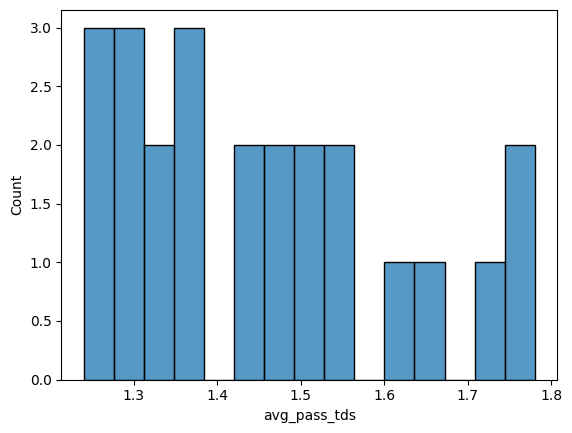

In [4]:
sns.histplot(
    x='avg_pass_tds',
    data=df,
    bins=15
)

<AxesSubplot: xlabel='avg_rush_tds', ylabel='Count'>

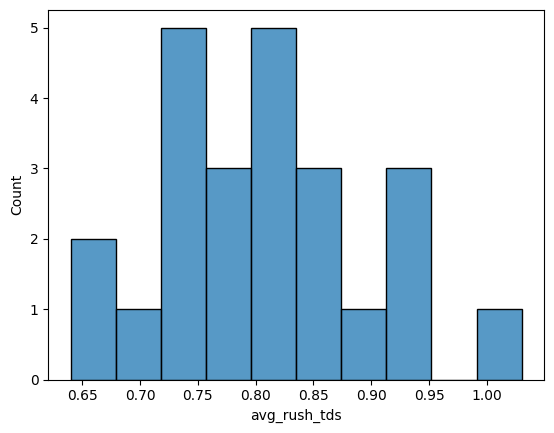

In [5]:
sns.histplot(
    x='avg_rush_tds',
    data=df,
    bins=10
)

<AxesSubplot: xlabel='avg_score', ylabel='Count'>

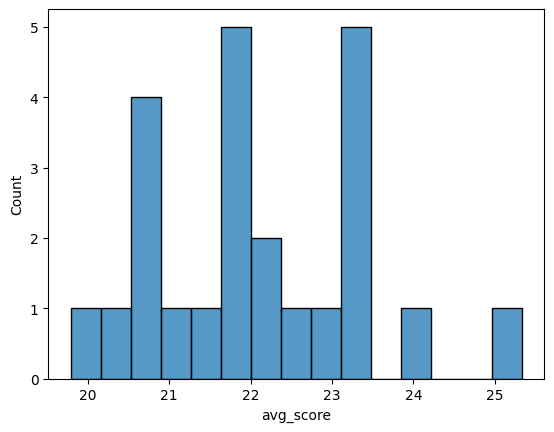

In [6]:
sns.histplot(
    x='avg_score',
    data=df,
    bins=15
)

## Hypothesis Testing

In [7]:
# Split dataset
by_season_2022 = df[df['season'] == 2022]
by_season_1999_2021 = df[df['season'] < 2022]

print(len(by_season_1999_2021))

23


In [8]:
def run_ttest(pop_sample, sample, metric, tail):
    # Get sample means
    boot_dist = []
    for i in range(10000):
        boot_dist.append(
            # Get point estimate
            np.mean(
                # Resample
                pop_sample.sample(frac=1, replace=True)[metric]
            )
        )

    # Confirm sample means are normally distributed
    g = sns.histplot(boot_dist, bins=50)
    # g.set(
    #     xlabel="Average Score",
    #     title="Bootstrap Distribution of 10,000 23-season Samples"
    # )
    # plt.show()
    return g, pingouin.ttest(boot_dist, sample[metric].iloc[0], alternative=tail)

/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


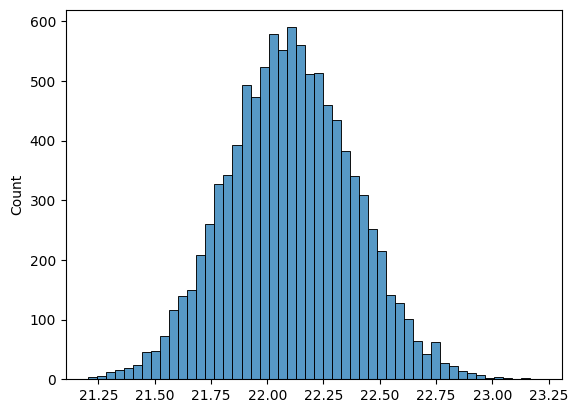

In [9]:
plot, ttest = run_ttest(by_season_1999_2021, by_season_2022, 'avg_score', 'less')

In [10]:

plt.show(plot)

In [11]:
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,105.241668,9999,less,1.0,"[-inf, 22.11]",1.052417,0.0e+00,0.0


/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


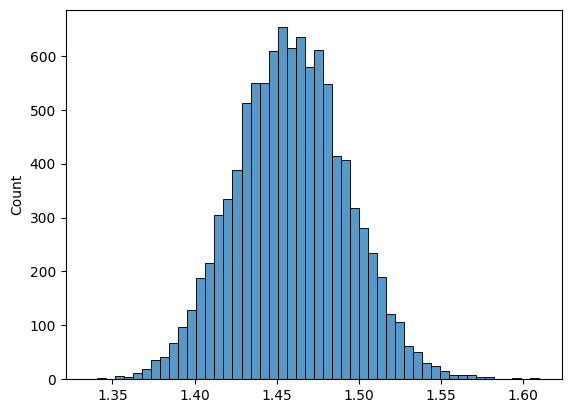

In [12]:
plot, ttest = run_ttest(by_season_1999_2021, by_season_2022, 'avg_pass_tds', 'less')

In [13]:
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,261.501966,9999,less,1.0,"[-inf, 1.46]",2.61502,0.0e+00,0.0


/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


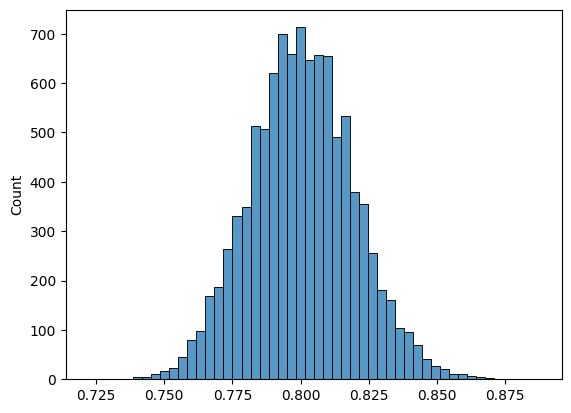

In [14]:
plot, ttest = run_ttest(by_season_1999_2021, by_season_2022, 'avg_rush_tds', 'less')

In [15]:
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-734.998543,9999,less,0.0,"[-inf, 0.8]",7.349985,inf,1.0


In [16]:
by_season_1999_2021.avg_rush_tds.describe()

count    23.000000
mean      0.800435
std       0.093783
min       0.640000
25%       0.750000
50%       0.800000
75%       0.855000
max       1.030000
Name: avg_rush_tds, dtype: float64

In [17]:
by_season_2022['avg_rush_tds']

23    0.94
Name: avg_rush_tds, dtype: float64

## Play By lay Data

In [18]:
import nfl_data_py as nfl

for i in nfl.see_pbp_cols():
    print(i)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


In [19]:
cols = [
    'game_id',
    'season',
    'week',
    'home_team',
    'away_team',
    'posteam',
    'defteam',
    'touchdown',
    'pass_touchdown',
    'rush_touchdown',
    'return_touchdown',
    'extra_point_attempt',
    'extra_point_result',
    'two_point_attempt',
    'field_goal_attempt',
    'field_goal_result',
    'two_point_conv_result',
    'safety',
    'success',
    'td_team',
    'desc']

pbp = nfl.import_pbp_data(range(1999, 2023), cols, downcast=True, cache=False, alt_path=None)

pbp.head()

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/nfl_data_py/__init__.py:137: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  plays.loc[:, cols] = plays.loc[:, cols].astype(numpy.float32)


,game_id,week,home_team,away_team,posteam,defteam,touchdown,pass_touchdown,rush_touchdown,return_touchdown,...,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense
0,1999_01_ARI_PHI,1,PHI,ARI,PHI,ARI,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999_01_ARI_PHI,1,PHI,ARI,PHI,ARI,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999_01_ARI_PHI,1,PHI,ARI,PHI,ARI,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1999_01_ARI_PHI,1,PHI,ARI,PHI,ARI,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999_01_ARI_PHI,1,PHI,ARI,PHI,ARI,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
pbp.columns

Index(['game_id', 'week', 'home_team', 'away_team', 'posteam', 'defteam',
       'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown',
       'extra_point_attempt', 'extra_point_result', 'two_point_attempt',
       'field_goal_attempt', 'field_goal_result', 'two_point_conv_result',
       'safety', 'success', 'td_team', 'desc', 'play_id', 'old_game_id',
       'season', 'nflverse_game_id', 'possession_team', 'offense_formation',
       'offense_personnel', 'defenders_in_box', 'defense_personnel',
       'number_of_pass_rushers', 'players_on_play', 'offense_players',
       'defense_players', 'n_offense', 'n_defense'],
      dtype='object')

In [21]:
pbp = pbp[cols]

pbp[pbp['touchdown'] == 1]

,game_id,season,week,home_team,away_team,posteam,defteam,touchdown,pass_touchdown,rush_touchdown,...,extra_point_attempt,extra_point_result,two_point_attempt,field_goal_attempt,field_goal_result,two_point_conv_result,safety,success,td_team,desc
16,1999_01_ARI_PHI,1999,1,PHI,ARI,PHI,ARI,1.0,0.0,1.0,...,0.0,None,0.0,0.0,None,None,0.0,1.0,PHI,"(11:28) D.Staley left guard for 24 yards, TOUC..."
40,1999_01_ARI_PHI,1999,1,PHI,ARI,PHI,ARI,1.0,1.0,0.0,...,0.0,None,0.0,0.0,None,None,0.0,1.0,PHI,(2:27) D.Pederson pass to D.Staley for 3 yards...
48,1999_01_ARI_PHI,1999,1,PHI,ARI,PHI,ARI,1.0,1.0,0.0,...,0.0,None,0.0,0.0,None,None,0.0,1.0,PHI,(1:19) D.Pederson pass to L.Broughton for 15 y...
118,1999_01_ARI_PHI,1999,1,PHI,ARI,ARI,PHI,1.0,0.0,1.0,...,0.0,None,0.0,0.0,None,None,0.0,1.0,ARI,"(15:00) M.Bates up the middle for 1 yard, TOUC..."
176,1999_01_ARI_PHI,1999,1,PHI,ARI,ARI,PHI,1.0,1.0,0.0,...,0.0,None,0.0,0.0,None,None,0.0,1.0,ARI,"(6:26) J.Plummer pass to R.Moore for 20 yards,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124796,2022_10_SEA_TB,2022,10,TB,SEA,TB,SEA,1.0,1.0,0.0,...,0.0,None,0.0,0.0,None,None,0.0,1.0,TB,(13:48) (Shotgun) 12-T.Brady pass short middle...
1124817,2022_10_SEA_TB,2022,10,TB,SEA,TB,SEA,1.0,0.0,1.0,...,0.0,None,0.0,0.0,None,None,0.0,1.0,TB,(4:33) (No Huddle) 7-L.Fournette right guard f...
1124883,2022_10_SEA_TB,2022,10,TB,SEA,TB,SEA,1.0,1.0,0.0,...,0.0,None,0.0,0.0,None,None,0.0,1.0,TB,(10:53) (Shotgun) 12-T.Brady pass short left t...
1124891,2022_10_SEA_TB,2022,10,TB,SEA,SEA,TB,1.0,1.0,0.0,...,0.0,None,0.0,0.0,None,None,0.0,1.0,SEA,"(8:24) (No Huddle, Shotgun) 7-G.Smith pass dee..."


In [22]:
pbp.value_counts('field_goal_result')

field_goal_result
made       19616
missed      3685
blocked      520
dtype: int64

In [23]:
pbp.value_counts('extra_point_result')

extra_point_result
good       28251
failed       607
blocked      179
aborted       31
dtype: int64

In [24]:
pbp.value_counts('two_point_conv_result')

two_point_conv_result
failure    1074
success     961
dtype: int64

Create a table that summarizes number of touchdowns, extra point, field goal, and safeties per game

In [25]:
pbp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124923 entries, 0 to 1124922
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   game_id                1124923 non-null  object 
 1   season                 1124923 non-null  int64  
 2   week                   1124923 non-null  int32  
 3   home_team              1124923 non-null  object 
 4   away_team              1124923 non-null  object 
 5   posteam                1048197 non-null  object 
 6   defteam                1048197 non-null  object 
 7   touchdown              1073236 non-null  float32
 8   pass_touchdown         1073236 non-null  float32
 9   rush_touchdown         1073236 non-null  float32
 10  return_touchdown       1073236 non-null  float32
 11  extra_point_attempt    1073236 non-null  float32
 12  extra_point_result     29068 non-null    object 
 13  two_point_attempt      1073236 non-null  float32
 14  field_goal_attempt

In [26]:
# Clean
pbp['extra_point_fixed'] = pbp['extra_point_result'].apply(lambda x: 1 if x=='good' else 0)
pbp['two_point_conv_fixed'] = pbp['two_point_conv_result'].apply(lambda x: 1 if x=='success' else 0)
pbp['field_goal_fixed'] = pbp['field_goal_result'].apply(lambda x: 1 if x=='made' else 0)

In [27]:
pbp.value_counts('field_goal_fixed')

field_goal_fixed
0    1105307
1      19616
dtype: int64

In [28]:
pbp.value_counts('field_goal_fixed')

field_goal_fixed
0    1105307
1      19616
dtype: int64

In [29]:
pbp.value_counts('two_point_conv_result')

two_point_conv_result
failure    1074
success     961
dtype: int64

In [81]:
metrics = [
    'pass_touchdown', 
    'rush_touchdown', 
    'return_touchdown', 
    'extra_point_fixed', 
    'two_point_conv_fixed', 
    'field_goal_fixed',
    'safety']

agg = pbp.groupby(['game_id', 'season', 'week'])[metrics].sum().reset_index()

In [82]:
agg['score'] = (agg['pass_touchdown'] * 6
                + agg['rush_touchdown'] * 6
                + agg['return_touchdown'] * 6
                + agg['extra_point_fixed'] * 1
                + agg['two_point_conv_fixed'] * 2
                + agg['field_goal_fixed'] * 3
                + agg['safety'] * 2
)

In [83]:
agg[agg['season'] == 2022]

,game_id,season,week,pass_touchdown,rush_touchdown,return_touchdown,extra_point_fixed,two_point_conv_fixed,field_goal_fixed,safety,score
6134,2022_01_BAL_NYJ,2022,1,4.0,0.0,0.0,3,0,2,0.0,33.0
6135,2022_01_BUF_LA,2022,1,4.0,1.0,0.0,5,0,2,0.0,41.0
6136,2022_01_CLE_CAR,2022,1,2.0,3.0,0.0,5,0,5,0.0,50.0
6137,2022_01_DEN_SEA,2022,1,3.0,0.0,0.0,3,0,4,0.0,33.0
6138,2022_01_GB_MIN,2022,1,2.0,1.0,0.0,3,0,3,0.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...
6278,2022_10_JAX_KC,2022,10,6.0,0.0,0.0,5,0,1,0.0,44.0
6279,2022_10_LAC_SF,2022,10,1.0,2.0,0.0,2,0,6,0.0,38.0
6280,2022_10_MIN_BUF,2022,10,2.0,4.0,1.0,6,0,5,0.0,63.0
6281,2022_10_NO_PIT,2022,10,1.0,2.0,0.0,3,0,3,0.0,30.0


In [33]:
agg[(agg['season'] == 2022) & (agg['safety'] == 1)]

,game_id,season,week,posteam,pass_touchdown,rush_touchdown,return_touchdown,extra_point_fixed,two_point_conv_fixed,field_goal_fixed,safety,score
12369,2022_02_ATL_LA,2022,2,LA,3.0,1.0,0.0,4,0,1,1.0,33.0
12397,2022_02_WAS_DET,2022,2,WAS,3.0,1.0,0.0,1,1,0,1.0,29.0
12403,2022_03_BUF_MIA,2022,3,MIA,1.0,2.0,0.0,3,0,0,1.0,23.0
12424,2022_03_PHI_WAS,2022,3,PHI,3.0,0.0,0.0,3,0,1,1.0,26.0
12429,2022_03_SF_DEN,2022,3,SF,1.0,0.0,0.0,1,0,1,1.0,12.0
12480,2022_05_MIA_NYJ,2022,5,MIA,0.0,2.0,0.0,2,0,1,1.0,19.0
12483,2022_05_NYG_GB,2022,5,NYG,0.0,3.0,0.0,3,0,2,1.0,29.0
12537,2022_07_KC_SF,2022,7,SF,2.0,0.0,0.0,2,0,3,1.0,25.0
12547,2022_07_SEA_LAC,2022,7,SEA,2.0,2.0,0.0,4,0,3,1.0,39.0


In [34]:
pbp['test'] = pbp['desc'].apply(lambda x: 1 if 'safety' in x else 0)

pbp['test'].value_counts()

0    1124890
1         33
Name: test, dtype: int64

In [35]:
type(pbp[pbp['safety'] == 1]['desc'])

pandas.core.series.Series

In [36]:
for item in pbp[pbp['safety'] == 1]['desc'].items():
    print(item)

(603, '(15:00) W.Brice punt is BLOCKED by D.Mitchell, Center-S.Bush, ball out of bounds in End Zone, SAFETY.')
(1018, '(10:26) J.Feagles Aborted. D.May FUMBLES at SEA 12, ball out of bounds in End Zone, SAFETY.')
(1752, '(:08) (Punt formation) L.Johnson Aborted. M.Bartrum FUMBLES at NE 0, ball out of bounds in End Zone, SAFETY.')
(2943, '(5:37) (Shotgun) T.Couch sacked in End Zone for -5 yards, SAFETY (sack split by E.Robinson and S.Rolle).')
(3385, '(15:00) J.Jett Aborted. A.Aldridge FUMBLES at DET 13, ball out of bounds in End Zone, SAFETY.')
(4936, "(5:29) T.Dilfer Aborted. T.Mayberry FUMBLES at TB 15, ball out of bounds in End Zone, SAFETY. Snap sails over TB12 T.Dilfer's head. He chases ball and bats it out of the end zone.")
(6334, '(3:37) P.Manning Aborted. L.Moore FUMBLES at IND 3, ball out of bounds in End Zone, SAFETY.')
(7508, '(:36) (Punt formation) C.Hentrich ran ob in End Zone for -11 yards, SAFETY NULLIFIED by Penalty. PENALTY on TEN, Offensive Holding, 11 yards, enforce

In [69]:
query = """
WITH home_games AS (
    SELECT
        game_id,
        season,
        week,
        home_team AS team,
        home_score AS score
    FROM schedules
    WHERE week <= 9
        AND game_type = 'REG'
), away_games AS (
    SELECT
        game_id,
        season,
        week,
        away_team AS team,
        away_score AS score
    FROM schedules
    WHERE week <= 9
        AND game_type = 'REG'
), stacked AS (
    SELECT *
    FROM home_games
    UNION ALL
    SELECT *
    FROM away_games
), data AS (
    SELECT
        s.game_id,
        s.season,
        s.week,
        s.team,
        s.score,
        weekly_totals.tot_pass_tds,
        weekly_totals.tot_rush_tds,
        weekly_totals.tot_rec_tds, -- Will be equal to pass tds but keeping in just in case
        weekly_totals.tot_st_tds
        --(s.score / weekly_totals.tot_pass_tds + weekly_totals.tot_rush_tds) AS score_off_td_pct
    FROM stacked s
    LEFT JOIN (
        SELECT
            season,
            week,
            recent_team,
            SUM(passing_tds) AS tot_pass_tds,
            SUM(rushing_tds) AS tot_rush_tds,
            SUM(receiving_tds) AS tot_rec_tds,
            SUM(special_teams_tds) AS tot_st_tds
        FROM weekly
        WHERE week <= 9
        GROUP BY season, week, recent_team
    ) AS weekly_totals
        ON weekly_totals.season = s.season
            AND weekly_totals.week = s.week
            AND weekly_totals.recent_team = s.team
)
SELECT *
FROM data
"""

df = pd.read_sql(query, conn)

In [72]:
df[(df['season'] == 1999) & (df['week'] == 1)]

,game_id,season,week,team,score,tot_pass_tds,tot_rush_tds,tot_rec_tds,tot_st_tds
0,1999_01_MIN_ATL,1999,1,ATL,14.0,1.0,1.0,1.0,0.0
1,1999_01_KC_CHI,1999,1,CHI,20.0,2.0,0.0,2.0,0.0
2,1999_01_PIT_CLE,1999,1,CLE,0.0,0.0,0.0,0.0,0.0
3,1999_01_OAK_GB,1999,1,GB,28.0,4.0,0.0,4.0,0.0
4,1999_01_BUF_IND,1999,1,IND,31.0,2.0,1.0,2.0,0.0
5,1999_01_SF_JAX,1999,1,JAX,41.0,1.0,1.0,1.0,1.0
6,1999_01_CAR_NO,1999,1,NO,19.0,1.0,0.0,1.0,1.0
7,1999_01_NE_NYJ,1999,1,NYJ,28.0,3.0,0.0,3.0,0.0
8,1999_01_ARI_PHI,1999,1,PHI,24.0,2.0,1.0,2.0,0.0
9,1999_01_DET_SEA,1999,1,SEA,20.0,2.0,0.0,2.0,0.0


In [77]:
df[df['team'] == 'LA'].sort_values(['season', 'week'])

,game_id,season,week,team,score,tot_pass_tds,tot_rush_tds,tot_rec_tds,tot_st_tds
5378,2016_01_LA_SF,2016,1,LA,0.0,0.0,0.0,0.0,0.0
2238,2016_02_SEA_LA,2016,2,LA,9.0,0.0,0.0,0.0,0.0
5405,2016_03_LA_TB,2016,3,LA,37.0,2.0,2.0,2.0,0.0
5421,2016_04_LA_ARI,2016,4,LA,17.0,2.0,0.0,2.0,0.0
2285,2016_05_BUF_LA,2016,5,LA,19.0,0.0,1.0,0.0,0.0
5443,2016_06_LA_DET,2016,6,LA,28.0,3.0,1.0,3.0,0.0
2305,2016_07_NYG_LA,2016,7,LA,10.0,1.0,0.0,1.0,0.0
2339,2016_09_CAR_LA,2016,9,LA,10.0,1.0,0.0,1.0,0.0
2354,2017_01_IND_LA,2017,1,LA,46.0,1.0,2.0,1.0,0.0
2372,2017_02_WAS_LA,2017,2,LA,20.0,1.0,1.0,1.0,0.0


In [39]:
agg

,game_id,season,week,posteam,pass_touchdown,rush_touchdown,return_touchdown,extra_point_fixed,two_point_conv_fixed,field_goal_fixed,safety,score
0,1999_01_ARI_PHI,1999,1,ARI,1.0,1.0,0.0,1,0,4,0.0,25.0
1,1999_01_ARI_PHI,1999,1,PHI,2.0,1.0,0.0,3,0,1,0.0,24.0
2,1999_01_BUF_IND,1999,1,BUF,1.0,0.0,1.0,0,1,2,0.0,20.0
3,1999_01_BUF_IND,1999,1,IND,2.0,1.0,0.0,4,0,1,0.0,25.0
4,1999_01_CAR_NO,1999,1,CAR,1.0,0.0,1.0,1,0,1,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12627,2022_10_MIN_BUF,2022,10,MIN,1.0,2.0,0.0,3,0,2,0.0,27.0
12628,2022_10_NO_PIT,2022,10,NO,1.0,0.0,0.0,1,0,1,0.0,10.0
12629,2022_10_NO_PIT,2022,10,PIT,0.0,2.0,0.0,2,0,2,0.0,20.0
12630,2022_10_SEA_TB,2022,10,SEA,2.0,0.0,0.0,1,0,1,0.0,16.0


In [60]:
agg[agg['week'] <= 9]['posteam_fixed'].value_counts()

CLE    201
NYJ    201
NE     201
DEN    200
NYG    199
LAC    199
IND    199
SF     198
KC     198
ATL    198
WAS    198
CIN    198
NO     198
CAR    198
PHI    198
TB     197
GB     197
BAL    197
MIN    197
SEA    197
DAL    197
TEN    197
BUF    197
JAX    196
ARI    196
LV     196
CHI    196
PIT    195
MIA    195
LA     194
DET    193
HOU    175
Name: posteam_fixed, dtype: int64

In [87]:
df

,game_id,season,week,team,score,tot_pass_tds,tot_rush_tds,tot_rec_tds,tot_st_tds
0,1999_01_MIN_ATL,1999,1,ATL,14.0,1.0,1.0,1.0,0.0
1,1999_01_KC_CHI,1999,1,CHI,20.0,2.0,0.0,2.0,0.0
2,1999_01_PIT_CLE,1999,1,CLE,0.0,0.0,0.0,0.0,0.0
3,1999_01_OAK_GB,1999,1,GB,28.0,4.0,0.0,4.0,0.0
4,1999_01_BUF_IND,1999,1,IND,31.0,2.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...
6297,2022_09_MIN_WAS,2022,9,MIN,20.0,2.0,0.0,2.0,0.0
6298,2022_09_SEA_ARI,2022,9,SEA,31.0,2.0,2.0,2.0,0.0
6299,2022_09_LA_TB,2022,9,LA,13.0,1.0,0.0,1.0,0.0
6300,2022_09_TEN_KC,2022,9,TEN,17.0,0.0,2.0,0.0,0.0


In [61]:
# Join datasets
merged = agg[agg['week'] <= 9].reset_index(drop=True).merge(
    right=df[['season', 'week', 'team', 'score']].reset_index(drop=True),
    how='left',
    left_on=['season', 'week', 'posteam_fixed'],
    right_on=['season', 'week', 'team']
)
merged.head()

,game_id,season,week,posteam_fixed,pass_touchdown,rush_touchdown,return_touchdown,extra_point_fixed,two_point_conv_fixed,field_goal_fixed,safety,score_x,team,score_y
0,1999_01_ARI_PHI,1999,1,ARI,1.0,1.0,0.0,1,0,4,0.0,25.0,ARI,25.0
1,1999_01_ARI_PHI,1999,1,PHI,2.0,1.0,0.0,3,0,1,0.0,24.0,PHI,24.0
2,1999_01_BUF_IND,1999,1,BUF,1.0,0.0,1.0,0,1,2,0.0,20.0,BUF,14.0
3,1999_01_BUF_IND,1999,1,IND,2.0,1.0,0.0,4,0,1,0.0,25.0,IND,31.0
4,1999_01_CAR_NO,1999,1,CAR,1.0,0.0,1.0,1,0,1,0.0,16.0,CAR,10.0


In [62]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6296 entries, 0 to 6295
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   game_id               6296 non-null   object 
 1   season                6296 non-null   int64  
 2   week                  6296 non-null   int64  
 3   posteam_fixed         6296 non-null   object 
 4   pass_touchdown        6296 non-null   float32
 5   rush_touchdown        6296 non-null   float32
 6   return_touchdown      6296 non-null   float32
 7   extra_point_fixed     6296 non-null   int64  
 8   two_point_conv_fixed  6296 non-null   int64  
 9   field_goal_fixed      6296 non-null   int64  
 10  safety                6296 non-null   float32
 11  score_x               6296 non-null   float64
 12  team                  5838 non-null   object 
 13  score_y               5838 non-null   float64
dtypes: float32(4), float64(2), int64(5), object(3)
memory usage: 639.4+ KB


In [63]:
merged[merged['score_y'].isna()]

,game_id,season,week,posteam_fixed,pass_touchdown,rush_touchdown,return_touchdown,extra_point_fixed,two_point_conv_fixed,field_goal_fixed,safety,score_x,team,score_y
23,1999_01_OAK_GB,1999,1,LV,0.0,3.0,0.0,3,0,1,0.0,24.0,NaN,NaN
46,1999_02_OAK_MIN,1999,2,LV,1.0,1.0,0.0,1,0,3,0.0,22.0,NaN,NaN
51,1999_02_SD_CIN,1999,2,LAC,2.0,0.0,0.0,2,1,4,0.0,28.0,NaN,NaN
59,1999_03_ATL_STL,1999,3,LA,3.0,2.0,0.0,5,0,0,0.0,35.0,NaN,NaN
61,1999_03_CHI_OAK,1999,3,LV,2.0,1.0,0.0,3,0,1,0.0,24.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,2019_04_OAK_IND,2019,4,LV,2.0,1.0,0.0,4,0,1,0.0,25.0,NaN,NaN
5351,2019_05_CHI_OAK,2019,5,LV,0.0,3.0,0.0,3,0,1,0.0,24.0,NaN,NaN
5423,2019_07_OAK_GB,2019,7,LV,3.0,0.0,0.0,3,0,1,0.0,24.0,NaN,NaN
5449,2019_08_OAK_HOU,2019,8,LV,3.0,0.0,0.0,3,0,1,0.0,24.0,NaN,NaN


In [44]:
pbp['posteam'].value_counts().sort_index().reset_index()

pbp[pbp['posteam'] == '']['defteam'].value_counts()

BUF    35
CHI     9
NE      5
DET     5
LV      5
PHI     4
TB      4
SF      4
CLE     3
CAR     3
TEN     2
LAC     2
DEN     2
LA      2
CIN     2
KC      2
DAL     2
NYG     2
SEA     1
NYJ     1
ATL     1
GB      1
IND     1
ARI     1
BAL     1
MIN     1
JAX     1
MIA     1
WAS     1
Name: defteam, dtype: int64

In [48]:
def posteam_fix(row):
    teams = []
    teams.append(row['home_team'])
    teams.append(row['away_team'])

    if row['posteam'] == '':
        teams.remove(row['defteam'])
        return teams[0]
    else:
        return row['posteam']



In [46]:
subset = pbp[pbp['posteam'] == '']
subset

,game_id,season,week,home_team,away_team,posteam,defteam,touchdown,pass_touchdown,rush_touchdown,...,field_goal_result,two_point_conv_result,safety,success,td_team,desc,extra_point_fixed,two_point_conv_fixed,field_goal_fixed,test
739,1999_01_CIN_TEN,1999,1,TEN,CIN,,TEN,0.0,0.0,0.0,...,None,None,0.0,0.0,None,Timeout #2 by TEN at 00:12.,0,0,0,0
1173,1999_01_KC_CHI,1999,1,CHI,KC,,CHI,NaN,NaN,NaN,...,None,None,NaN,0.0,None,END QUARTER 1,0,0,0,0
1174,1999_01_KC_CHI,1999,1,CHI,KC,,CHI,NaN,NaN,NaN,...,None,None,NaN,0.0,None,CHI- C.McNown in at QB.,0,0,0,0
1282,1999_01_KC_CHI,1999,1,CHI,KC,,CHI,NaN,NaN,NaN,...,None,None,NaN,0.0,None,END QUARTER 3,0,0,0,0
2804,1999_02_ATL_DAL,1999,2,DAL,ATL,,DAL,0.0,0.0,0.0,...,None,None,0.0,0.0,None,Timeout #2 by ATL at 03:16.,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85906,2000_16_NE_BUF,2000,16,BUF,NE,,BUF,NaN,NaN,NaN,...,None,None,NaN,0.0,None,End of quarter - 3:10 pm,0,0,0,0
85907,2000_16_NE_BUF,2000,16,BUF,NE,,BUF,NaN,NaN,NaN,...,None,None,NaN,0.0,None,END QUARTER 3,0,0,0,0
85963,2000_16_NE_BUF,2000,16,BUF,NE,,BUF,0.0,0.0,0.0,...,None,None,0.0,0.0,None,Timeout #3 by NE at 00:01.,0,0,0,0
87208,2000_17_ARI_WAS,2000,17,WAS,ARI,,WAS,0.0,0.0,0.0,...,None,None,0.0,1.0,None,Timeout #3 by ARI at 03:38.,0,0,0,0


In [49]:
subset['posteam_fixed'] = subset.apply(lambda row: posteam_fix(row), axis=1)

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_88936/3464738728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['posteam_fixed'] = subset.apply(lambda row: posteam_fix(row), axis=1)


In [50]:
subset

,game_id,season,week,home_team,away_team,posteam,defteam,touchdown,pass_touchdown,rush_touchdown,...,two_point_conv_result,safety,success,td_team,desc,extra_point_fixed,two_point_conv_fixed,field_goal_fixed,test,posteam_fixed
739,1999_01_CIN_TEN,1999,1,TEN,CIN,,TEN,0.0,0.0,0.0,...,None,0.0,0.0,None,Timeout #2 by TEN at 00:12.,0,0,0,0,CIN
1173,1999_01_KC_CHI,1999,1,CHI,KC,,CHI,NaN,NaN,NaN,...,None,NaN,0.0,None,END QUARTER 1,0,0,0,0,KC
1174,1999_01_KC_CHI,1999,1,CHI,KC,,CHI,NaN,NaN,NaN,...,None,NaN,0.0,None,CHI- C.McNown in at QB.,0,0,0,0,KC
1282,1999_01_KC_CHI,1999,1,CHI,KC,,CHI,NaN,NaN,NaN,...,None,NaN,0.0,None,END QUARTER 3,0,0,0,0,KC
2804,1999_02_ATL_DAL,1999,2,DAL,ATL,,DAL,0.0,0.0,0.0,...,None,0.0,0.0,None,Timeout #2 by ATL at 03:16.,0,0,0,0,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85906,2000_16_NE_BUF,2000,16,BUF,NE,,BUF,NaN,NaN,NaN,...,None,NaN,0.0,None,End of quarter - 3:10 pm,0,0,0,0,NE
85907,2000_16_NE_BUF,2000,16,BUF,NE,,BUF,NaN,NaN,NaN,...,None,NaN,0.0,None,END QUARTER 3,0,0,0,0,NE
85963,2000_16_NE_BUF,2000,16,BUF,NE,,BUF,0.0,0.0,0.0,...,None,0.0,0.0,None,Timeout #3 by NE at 00:01.,0,0,0,0,NE
87208,2000_17_ARI_WAS,2000,17,WAS,ARI,,WAS,0.0,0.0,0.0,...,None,0.0,1.0,None,Timeout #3 by ARI at 03:38.,0,0,0,0,ARI


In [51]:
pbp['posteam_fixed'] = pbp.apply(lambda row: posteam_fix(row), axis=1)

In [67]:
df['team'].value_counts().sort_index()

ARI    196
ATL    198
BAL    198
BUF    198
CAR    198
CHI    196
CIN    198
CLE    201
DAL    197
DEN    200
DET    193
GB     197
HOU    175
IND    199
JAX    196
KC     199
LA      58
LAC     49
LV      24
MIA    196
MIN    197
NE     201
NO     198
NYG    199
NYJ    201
OAK    172
PHI    198
PIT    195
SD     151
SEA    197
SF     198
STL    137
TB     197
TEN    197
WAS    198
Name: team, dtype: int64

In [68]:
df[df['team'] == 'LA']

,season,week,team,score,tot_pass_tds,tot_rush_tds,tot_rec_tds,tot_st_tds
2238,2016,2,LA,9.0,0.0,0.0,0.0,0.0
2285,2016,5,LA,19.0,0.0,1.0,0.0,0.0
2305,2016,7,LA,10.0,1.0,0.0,1.0,0.0
2339,2016,9,LA,10.0,1.0,0.0,1.0,0.0
2354,2017,1,LA,46.0,1.0,2.0,1.0,0.0
2372,2017,2,LA,20.0,1.0,1.0,1.0,0.0
2417,2017,5,LA,10.0,0.0,1.0,0.0,0.0
2442,2017,7,LA,33.0,1.0,2.0,1.0,0.0
2503,2018,2,LA,34.0,1.0,3.0,1.0,0.0
2520,2018,3,LA,35.0,3.0,1.0,3.0,1.0
